### Esame di Analisi Dati in Fisica Subnucleare del 14 luglio 2023. Tema: Programmazione in Python
# Stima della densità di probabilità con meteodi kernel

In questo tema studieremo un metodo per stimare, noto un campione di dati,
la distribuzione di probabilità che li ha generati.

In particolare utilizzeremo un metodo *kernel* che rappresenta la distribuzione come somma di distribuzioni di probabilità centrate ciascuna su un punto del campione di dati noto (*training sample*).

In formula,
$$
\hat f(x) = \frac{1}{N} \sum_{i = 1}^{N} \frac{1}{\sqrt{2\pi}\ \sigma_i}
 \exp \left(-\frac{1}{2}\frac{(x - x_i)^2}{\sigma_i^2}
\right)
$$
dove l'indice $i$ corre sui campionamenti $x_i$ e $\sigma_i$ è detta \emph{larghezza di banda} (o \emph{bandwidth}) e, in generale, può differire da campionamento a campionamento.  

Per studiare questo metodo, utilizzermo un dataset di dati reali acquisiti da LHCb, in cui sono selezionati candidati di decadimento $D^0 \to K^- \pi^+$.

## Librerie utilizzate

Le librerie utilizzate in questo tema d'esame sono:
 * `numpy` per il calcolo numerico
 * `pyplot` per le rappresentazioni grafiche
 * `uproot` per caricare dati in formato ROOT
 * `iminuit` per le ottimizzazioni numeriche

Per alcuni passaggi potrebbe essere d'aiuto `pandas` (che potete usare, se volete, così come qualunque altra libreria) ma che non è indispensabile.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

!pip install -q uproot iminuit
import uproot
import iminuit

## Dataset, contesto e analisi esplorativa

Il dataset è ottenuto dal portale *OpenData* del CERN all'indirizzo: https://opendata.cern.ch/record/401/files/MasterclassData.root.

Pur contenendo diverse variabili, ai fini dell'esercizio ci limiteremo a:
 * `D0_TAU` (caricata come `decaytime`), il tempo di decadimento proprio del mesone $D^0$;
 * `D0_MM` (caricata come `mass`), la massa invariante ricostruita combinando i prodotti di decadimento del candidato $D^0$, ossia il kaone ed il pione.

 Nella cella seguente, le variabili vengono caricate in memoria, dopo aver ottenuto il file da Internet.

Le unità di misura con cui sono espresse le variabili nel dataset originale sono $\mathrm{ns}$ e $\mathrm{MeV}/c^2$. Trasformiamo il tempo di decadimento in picosecondi, più adatto allo scopo.


In [ ]:
## Download the dataset from CERN OpenData
!wget https://opendata.cern.ch/record/401/files/MasterclassData.root -qO data.root

## Extract decaytime and mass arrays
f = uproot.open("data.root")
decaytime = f['DecayTree'].arrays(library='np')['D0_TAU']
mass = f['DecayTree'].arrays(library='np')['D0_MM']

## Converts to picoseconds
decaytime *= 1e3

## Esercizio 1. Analisi esplorativa.
Costruire l'istogramma delle misure della massa e del tempo di decadimento.

Dovreste ottenere qualcosa di analogo alla figura seguente.

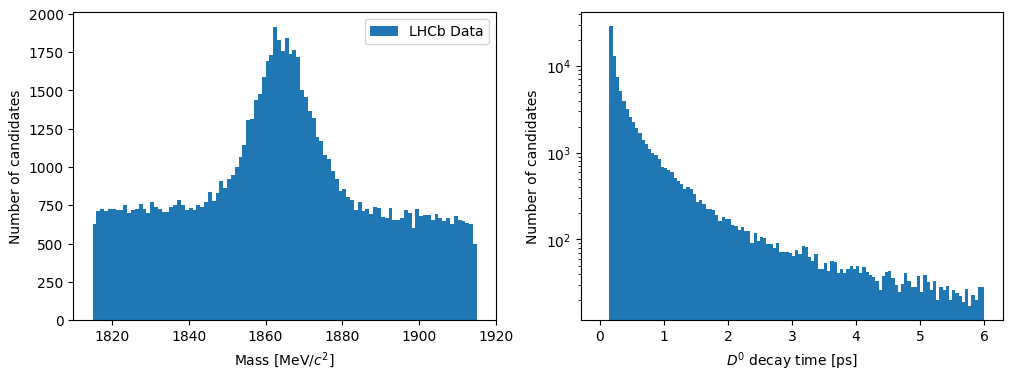

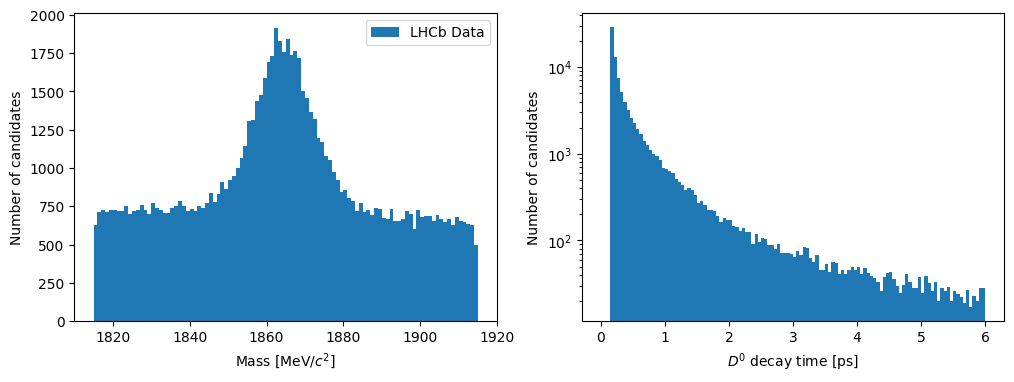

In [ ]:
## Soluzione
##-----------
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.hist(mass, bins=np.linspace(1815, 1915, 101), label="LHCb Data")
plt.xlabel("Mass [MeV/$c^2$]")
plt.ylabel("Number of candidates")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(decaytime, bins=np.linspace(0, 6, 121))
plt.yscale('log')
plt.xlabel("$D^0$ decay time [ps]")
plt.ylabel("Number of candidates")

plt.show()

Da questi due istogrammi vanno tratte due conclusioni importanti:
 * la distribuzione delle masse è composta da due contributi, uno che picca intorno a 1865 MeV/$c^2$ (dovuta a decadimenti  $D^0 \to K^- \pi^+$) sovrapposta ad una componente sostanzialmente uniforme dovuta a combinazioni casuali di *pioni* e *kaoni*.
 * la distribuzione del tempo di decadimento **non** è semplicemente un esponenziale decrescente, come ci si aspetterebbe per il decadimento di una particella, ma è più complicata.

Sembra ragionevole presumere che la ragione per la quale la distribuzione dei tempi non è una funzione esponenziale decrescente sia dovuto ai tempi di decadimento ricostruiti per combinazioni casuali di kaoni e pioni.

Vogliamo costruire un modello statistico per la componente "di fondo" della distribuzione dei tempi di decadimento.

## Esercizio 2. Tempo di decadimento delle combinazioni casuali

Mentre non possiamo selezionare un campione puro di decadimenti $D^0 \to K^- \pi^+$ date le variabili discusse sopra, è possibile selezionare un campione di solo fondo combinatorio utilizzando le bande laterali della distribuzione della massa (*mass sidebands*).

Selezionate quei valori di `decaytime` che corrispondono a valori di `mass` inferiori a $1840\ \mathrm{MeV}/c^2$ **oppure** superiori a $1890\ \mathrm{MeV}/c^2$

In [ ]:
## Soluzione
##-----------
bkg_decaytime = decaytime[(mass < 1840) | (mass > 1890)]

Quindi, sovrapponete l'istogramma dei tempi di decadimento selezionati a quelli dell'intero dataset, ottenendo una figura analoga alla seguente.

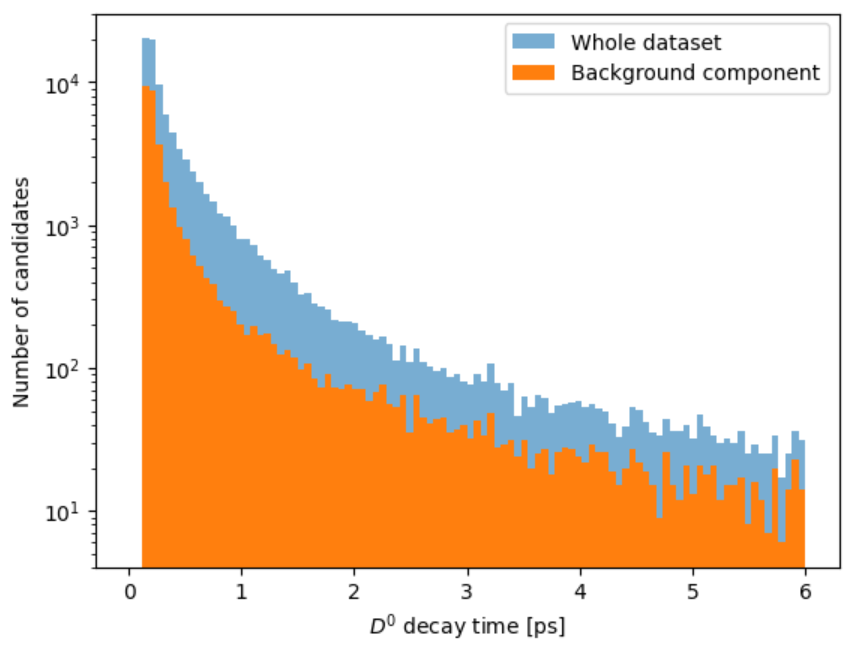

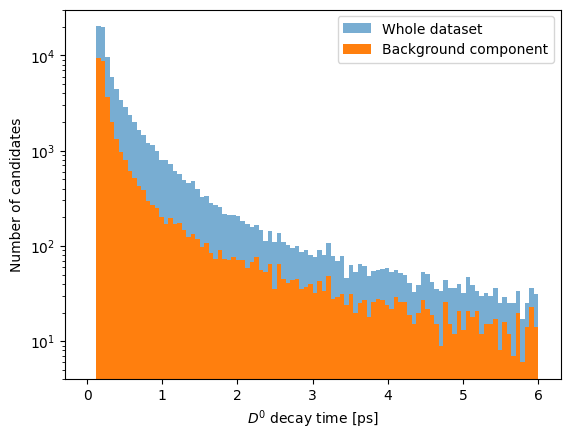

In [ ]:
## Soluzione
##-----------
plt.hist(decaytime, bins=np.linspace(0, 6, 101), alpha=0.6, label="Whole dataset")
plt.hist(bkg_decaytime, bins=np.linspace(0, 6, 101), label="Background component")

plt.yscale('log')
plt.legend()
plt.xlabel("$D^0$ decay time [ps]")
plt.ylabel("Number of candidates")

plt.show()

## Esercizio 3. Costruzione della KDE

Come abbiamo anticipato nell'introduzione vogliamo rappresentare la funzione generatrice del campione di tempi di decadimento di eventi di fondo come la somma di gaussiane centrate nei valori di un campione "di addestramento", secondo la formula
$$
\hat f(x) = \frac{1}{N} \sum_{i = 1}^{N} \frac{1}{\sqrt{2\pi}\ \sigma_i}
 \exp \left(-\frac{1}{2}\frac{(x - x_i)^2}{\sigma_i^2}
\right)
$$

In cui la scelta dei valori $\sigma_i$ è sostanzialmente arbitraria.

Come sempre quando abbiamo parametri addestrabili, occorre poter verificare che il modello ottenuto con la nostra scelta **generalizzi** a campioni statisticamente equivalenti ma indipendenti da quello usato per l'addestramento.

Per prima cosa dividiamo quindi il nostro campione di tempi di decadimento in due parti uguali che indicheremo come *campioni di train* e *di test*.

Ci sono diversi metodi per ottenere questo risultato in una riga, alcune funzioni da considerare potrebbero essere per esempio:
 * [numpy.split](https://numpy.org/doc/stable/reference/generated/numpy.split.html)
 * [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
 * [pandas.DataFrame.sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)


In [ ]:
## Soluzione
##-----------
train_set, test_set = np.split(bkg_decaytime, 2)

Ora, il nostro obiettivo è valutare la funzione $\hat f$ definita sopra sui punti del campione di *test*.
La riscriviamo per chiarezza come
$$
\hat f(x_j) = \frac{1}{N} \sum_{i = 1}^{N} \frac{1}{\sqrt{2\pi}\ \sigma_i}
 \exp \left(-\frac{1}{2}\frac{(x_j - x_i)^2}{\sigma_i^2}
\right)
$$
dove $x_i$ corre sul campione di *training* mentre $x_j$ corre sul campione di *test*.

Oppure,
$$
\hat f(x_j) = \frac{1}{N} \sum_{i = 1}^{N} \frac{1}{\sqrt{2\pi}\ \sigma_i}
 \exp \left(-\frac{1}{2}Z_{ji}^2
\right)
 \qquad \mbox{con} \qquad
Z_{ji} = \frac{x_j - x_i}{\sigma_i}
$$

La funzione sotto consente di calcolare $Z_{ji}$ dati i campioni di test e di training


In [ ]:
def z_ji (
    test_set,      # numpy array of x_j
    train_set,     # numpy array of x_i
    sigma_train,   # numpy array (or scalar) with the same size of train_set
  ):
  return (test_set[:,None] - train_set) / sigma_train

Data la funzione `f_ji` si definisca quindi una funzione per calcolare $\hat f(x_j)$

> **Suggerimento.**  La funzione potrebbe assomigliare a
> ```python
> def f_xj (test_set, bandwidth):
>   return np.mean( [...] z_ij(test_set, train_set, bandwidth)**2 [...],  axis=1)
>   
> ```
> dove `[...]` indica codice mancante da completare.

In [ ]:
## Soluzione
def f_xj (test_set, bandwidth):
  return np.mean( 1./np.sqrt(2*np.pi)/bandwidth * np.exp( -0.5 * z_ji(test_set, train_set, bandwidth)**2 ),  axis=1)

Alcune verifiche che potete fare per verificare che il codice funzioni includono:
 * ```python
   len (f_xj(np.array([1,2,3]), 1e-2)) == 3
  ```
 * ```python
   f_xj(np.array([0]), 1e-8) == [0]
  ```
 * ```python
   f_xj(np.array([2]), 1e3) == f_xj(np.array([2]), 1e3)
  ```

Infatti, se la funzione `f_xj` è implementata correttamente, queste tre condizioni dovrebbero risultare vere.
  


In [ ]:
## Soluzione
##-----------
print (len(f_xj(np.array([1,2,3]), 1e-2)) == 3)
print (f_xj(np.array([0]), 1e-8) == [0])
print (f_xj(np.array([2]), 1e3) == f_xj(np.array([2]), 1e3))

True
[ True]
[ True]


## Esercizio 4. Densità di probabilità con larghezza di banda costante
Si sovrapponga la stima ottenuta con `f_xj` all'istogramma dei tempi di decadimento, utilizzando delle larghezze di banda pari per esempio a `0.001 ps` e a `0.1 ps`.

Alcune note:
 * la [funzione `plt.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) consente di rappresentare la densità di probabilità associata all'istogramma (quindi, rinormalizzando opportunamente) definendo l'argomento `density=True`.
 * se scegliete di rappresentare il grafico in scala semilogaritmica, potreste dover fissare la scala delle ordinate utilizzando [`plt.ylim(y_min, y_max)`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html).

Dovreste ottenere un grafico come il seguente.

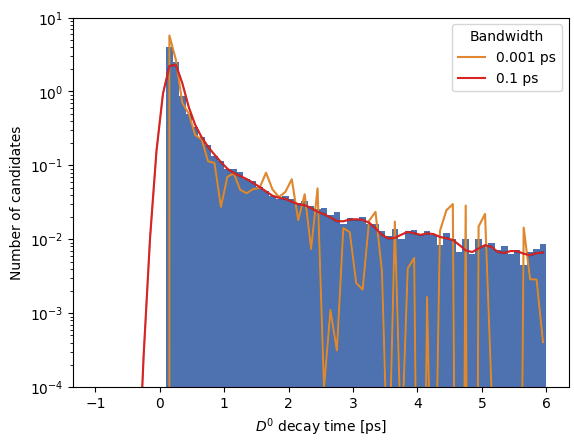

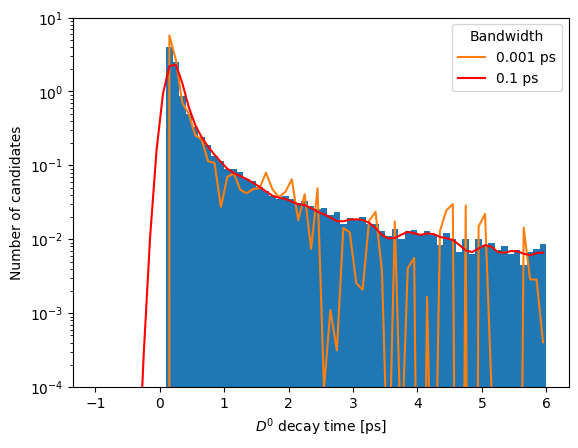

In [ ]:
## Soluzione
##-----------
bins = np.linspace(-1, 6, 71)
xAxis = 0.5 * (bins[1:] + bins[:-1])
plt.hist(bkg_decaytime, bins, density=True)
bin_width = bins[1]-bins[0]
plt.plot(xAxis, f_xj(xAxis, 1e-3), label="0.001 ps")
plt.plot(xAxis, f_xj(xAxis, 1e-1), label="0.1 ps", color='red')
plt.yscale('log')
plt.ylim(1e-4, 1e1)
plt.legend(title='Bandwidth')
plt.xlabel("$D^0$ decay time [ps]")
plt.ylabel("Number of candidates")
plt.show()

Dalla figura ottenuta possiamo concludere che usare una larghezza di banda costante è chiaramente una scelta non ottimale.

Con larghezze di banda "piccole" (per esempio 1 fs), abbiamo una buona descrizione del picco, ma la descrizione della coda risulta molto oscillante e ruomorosa.

Viceversa, utilizzando larghezze di banda "grandi" (per esempio 100 fs), la coda risulta ben descritta, ma il picco è troppo allargato e smussato.



## Esercizio 5. Larghezza di banda linearmente variabile

Proviamo allora a far variare la larghezza di banda in funzione di $x_i$, ossia del valore assunto dal campione di training.

Considerate la funzione
```python
def kde(test_set, bw_q, bw_m):
  bandwidth = bw_q + bw_m * train_set
  return f_xj(test_set, bandwidth)
```
e sovrapponete la stima di densità ottenuta per `bw_q = 0.001` ps e `bw_m = 0.1` ps all'istogramma dei tempi di decadimento.

Dovreste ottenere un grafico simile a quello nella figura qui sotto.

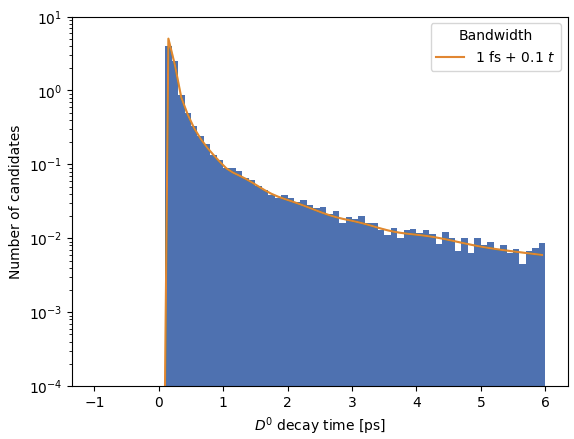

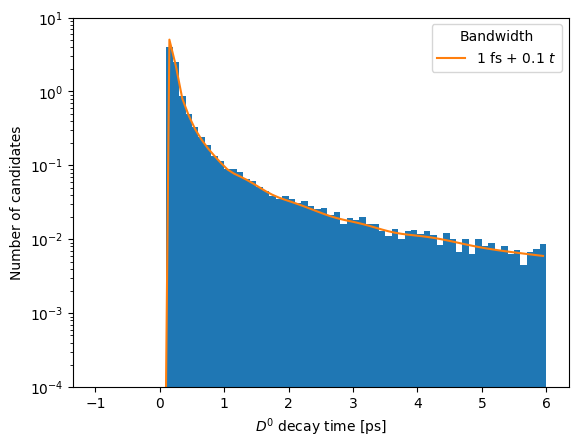

In [ ]:
## Soluzione
##-----------
def kde(test_set, bw_q, bw_m):
  bandwidth = bw_q + bw_m * train_set
  return f_xj(test_set, bandwidth)

bins = np.linspace(-1, 6, 71)
xAxis = 0.5 * (bins[1:] + bins[:-1])
plt.hist(bkg_decaytime, bins, density=True)
plt.plot(xAxis, kde(xAxis, 1e-3, 1e-1), label="1 fs + 0.1 $t$")
plt.yscale('log')
plt.ylim(1e-4, 1e1)
plt.legend(title='Bandwidth')
plt.xlabel("$D^0$ decay time [ps]")
plt.ylabel("Number of candidates")
plt.show()

## Eserizio 6. Ottimizzare i valori di `bw_q` e `bw_m` con un fit di massima verosimiglianza

Data la distribuzione di probabilità $\hat f(x; q_{bw}, m_{bw})$, possiamo cercare di ottimizzare i parametri $q_{bw}$ e $m_{bw}$ con un fit di massima verosimiglianza utilizzando `iminuit`.

Per prima cosa dobbiamo definire la funzione verosimiglianza ed implementarne il calcolo. Come sappiamo,
$$
\mathcal L = \prod_j \hat f(x_j; q_{bw}, m_{bw})
$$

Quindi dobbiamo ricordare che massimizzare la verosimiglianza equivale a minimizzare l'opposto del suo logaritmo, ossia la *negative log likelihood*.
$$
-\log \mathcal L = - \sum_j \log \hat f(x_j; q_{bw}, m_{bw})
$$


Inoltre, per proteggere l'ottimizzazione numerica dai casi in cui l'argomento del logaritmo si avvicini troppo a zero, generando instabilità numeriche,
calcoliamo il logaritmo come
`np.log(x)` $\to$ `np.log(np.clip(x, 1e-8, None))`.

Con queste accortezze si definisca la funzione `nLL(bw_q, bw_m)` e la si ottimizzi rispetto ai parametri `bw_q` e `bw_m`.

<font color='red'>Importante!</font>

**Sebbene la sommatoria su $j$ nella formula sopra dovrebbe correre sull'intero campione di test, potete limitarvi a qualche centinaia di valori ai fini dell'esercizio, altrimenti il tempo di calcolo risulta fastidiosamente lungo.**

In [ ]:
## Soluzione
##-----------
opt_set = test_set[:1000]

def nLL(bw_q, bw_m):
  negative_log_likelihood = -np.sum(np.log(np.clip(kde(opt_set, bw_q, bw_m), 1e-8, None)))
  return negative_log_likelihood

m = iminuit.Minuit (nLL, 1e-2, 0)
m.errordef = 0.5
m.simplex(ncall=None)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -139.6                     │              Nfcn = 136              │
│ EDM = 0.0263 (Goal: 0.05)        │           time = 32.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ bw_q │  -9.1e-3  │  0.8e-3   │            │            │         │         │       │
│ 1 │ bw_m │   0.060   │   0.005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Rappresentando questa versione ottimizzata della stima di densità sovrapposta all'istogramma, dovreste ottenere qualcosa di analogo alla figura seguente.


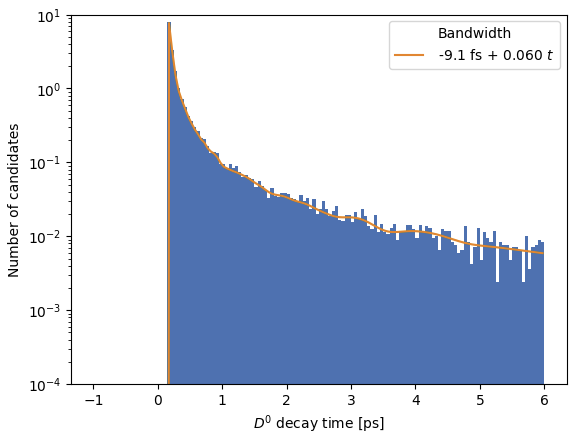

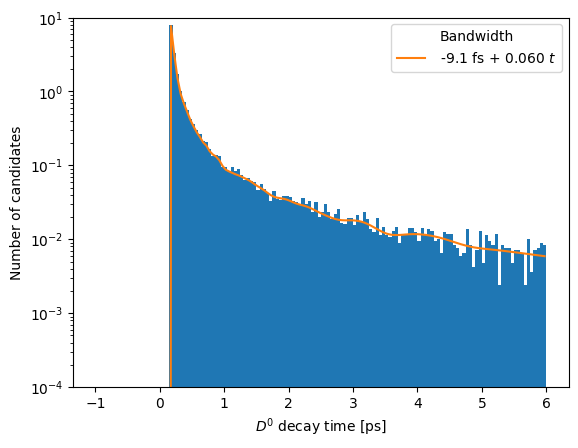

In [ ]:
## Soluzione
##-----------
bins = np.linspace(-1, 6, 141)
xAxis = 0.5 * (bins[1:] + bins[:-1])
plt.hist(bkg_decaytime, bins, density=True)
plt.plot(xAxis, kde(xAxis, *m.values), label=f" {m.values[0]*1e3:.1f} fs + {m.values[1]:.3f} $t$")
plt.yscale('log')
plt.ylim(1e-4, 1e1)
plt.legend(title='Bandwidth')
plt.xlabel("$D^0$ decay time [ps]")
plt.ylabel("Number of candidates")
plt.show()

## Conclusioni

In questo tema d'esame abbiamo studiato un metodo di stima non parametrica della densità, basata su funzioni kernel.
Ne abbiamo visto una applicazione alla stima della densità dei tempi di decadimento di mesoni $D^0$ per la componente di fondo combinatorio.

La distribuzione di questa componente non è un esponenziale perché non deriva dal decadimento reale di mesoni $D^0$ ma è una forma più complessa che può essere parametrizzata in vari modi.

Utilizzando i metodi *kernel* dobbiamo stare attenti a scegliere un valore ottimale per la larghezza di banda, o *bandwidth* che rappresenta la larghezza di ciascuna gaussiana che compone la stima della densità.

Nel caso di distribuzioni con lunghe code (come quella che stiamo studiando) è però possibile che non esista un singolo valore ottimale e che sia necessario scegliere il valore della *bandwidth* in funzione dell'elemento del campione di training a cui essa è associata. In questo eserizio abbiamo scelto di var variare la *bandwidth* linearmente rispetto al tempo di decadimento.

Infine abbiamo ottimizzato i valori della dipendenza lineare utilizzando un fit non binnato di massima likelihood, ottenendo così una scelta ottimale della larghezza di banda.

La parametrizzazione così ottenuta per la componente di solo fondo è spesso usata per sottrarre la componente di fondo dall'istogramma nella regione di segnale e ottenere così, per sottrazione, l'istogramma della componente di solo segnale. Quest'ultima può essere utilizzata, ad esempio, per misurare la vita media del mesone $D^0$. Ma questo è un altro esercizio.


